In [1]:
# No need to see warnings here
import warnings
warnings.filterwarnings("ignore")
# Matplotlib stuff for plotting
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# h5py to open the hdf5 files
import h5py
# numpy for practically everything
import numpy as np
# setup numpy print options to make it easier on the eyes
np.set_printoptions(precision=2)
# Analysis libraries
import networkx as nx
import pyemma as pe
# Custom functions for this notebook
import analysis_helper as ahelper

We will be working with a rule based model of the exclusive mutual inhibition and self-activation (ExMISA) motif. This is a common motif in biology and one of the models studied with the weighted ensemble method [here](https://arxiv.org/pdf/1712.08710.pdf)

Instead of the workflow mentioned in the study, we will use WESTPA and some WESTPA tools combined with the libraries mentioned in that paper for analysis. The simulation provided here is a 100 WE iterations with the same parameters as the study. Note that a 100 iterations is not enough to converge sampling but it can get pretty close (slightly depending on the stochasticity). In particular, you should be able to see the 4 main stable states (phenotypes) that are mentioned in the paper.

# Master WESTPA H5 file

The most important file for WESTPA simulations is the master WESTPA h5 file which is where the progress coordinates and weights are stored. There are quite a few ways to explore these files, the one I prefer is to use the python interface for this file format, [HDF5](https://support.hdfgroup.org/HDF5/) called [h5py](https://www.h5py.org/).

In [2]:
# Try loading user generated, fall back to pre-generated
try:
    h = h5py.File('../west.h5', 'r')
except:
    h = h5py.File('pre_prepped_results/west.h5', 'r')
print(", ".join(h.keys()))

bin_topologies, ibstates, iterations, summary, tstates


HDF5 is a hierarchical file format. Basically you navigate it almost like a file system where the top of the tree is the file e.g. west.h5/iterations/iter_00000001/pcoord etc. Here you can see the options you have at the top of the tree: 

* bin_topologies contain the mappers used for the simulation, it's possible to pull the mapper object out of the file 
* ibstates contain information regarding the basis (and initial) state information
* iterations contain all the information on a per iteration basis
* summary gives you a nice overall summary of the simulation including the # of walkers per iteration and how much time each 
   iteration took
* tstates contains information regarding target states

Let's check out what's contained in the summary section

In [3]:
h['summary'][10:15]

array([(100, 1., 0.01, 0.38, 0., 0.06, 11.13, 2.14, ''),
       (110, 1., 0.  , 0.28, 0., 0.04, 12.5 , 2.41, ''),
       (120, 1., 0.  , 0.23, 0., 0.03, 13.58, 2.55, ''),
       (130, 1., 0.  , 0.28, 0., 0.04, 14.47, 2.49, ''),
       (120, 1., 0.01, 0.41, 0., 0.06, 12.77, 2.43, '')],
      dtype=[('n_particles', '<i8'), ('norm', '<f8'), ('min_bin_prob', '<f8'), ('max_bin_prob', '<f8'), ('min_seg_prob', '<f8'), ('max_seg_prob', '<f8'), ('cputime', '<f8'), ('walltime', '<f8'), ('binhash', 'S64')])

Let's see what we have in each iteration

In [4]:
print(", ".join(h['iterations/iter_%08d'%10].keys()))

bin_target_counts, ibstates, pcoord, seg_index, wtgraph


* bin_target_counts give you how many walkers per bin we have
* ibstates is basically the same as before, for this iteration (important for recycling)
* pcoord contains your progress coordinates for the entire iteration
* seg_index includes information regarding the specific walker, like the history parent id or recycling status
* wtgraph includes all parents, not just the history parent
* additional data that can be passed to WESTPA will be stored here under 'auxdata'

seg_index includes important information regarding the history parents of each walker (parent_id) and if a walker 
is recycled or not (endpoint_type). 

In [5]:
print(h['iterations/iter_%08d'%10]['seg_index'][...].shape)
h['iterations/iter_%08d'%10]['seg_index'][10:15]

(90,)


array([(0., 25, 1, 27, 0.17, 0.19, 1, 2),
       (0., 66, 2, 28, 0.12, 0.13, 1, 2),
       (0., 25, 1, 30, 0.17, 0.18, 1, 2),
       (0., 25, 1, 31, 0.17, 0.18, 2, 2),
       (0., 25, 1, 32, 0.15, 0.16, 2, 2)],
      dtype=[('weight', '<f8'), ('parent_id', '<i8'), ('wtg_n_parents', '<u8'), ('wtg_offset', '<u8'), ('cputime', '<f8'), ('walltime', '<f8'), ('endpoint_type', 'u1'), ('status', 'u1')])

wtgraph includes all parent information (not just the history parent)

In [6]:
print(h['iterations/iter_%08d'%10]['wtgraph'][...].shape)
h['iterations/iter_%08d'%10]['wtgraph'][10:20]

(123,)


array([ 6, 16, 11, 50, 67, 55, 56, 15, 59, 13])

Assuming you collected all the information you need during the simulation, you should only need the master h5 file for all of your analysis. For simulations that generate a very large amount of information for every single walker (e.g. an all-atom explicit solvent MD simulation) this might not be possible. If you can afford to save everything here, I suggest doing so since it makes analysis a lot easier down the line. 

# w_assign and the assign.h5 file

A very important and general WESTPA tool is called w_assign which can be used to assign indices to each walker, with the goal of making analysis easier. For example, you want to calculate a particular property (say \[A\]) in a particular region of state space. You can label that region of the state space and use the indices stored in the assign.h5 file for calculating average \[A\] in that region. 

It's highly flexible since you can pass a python function to determine the index of each walker. E.g. you can make a clustering using your WESTPA data and use the function to assign each walker to one of the clusters, you can manually partition the entire state space you have and give each walker an index showing which partition it belongs to. However you want to label each walker, you can do so if you can code the function.

By default w_assign will use the bin mapper found in the master WESTPA h5 file. Also, if unless a python function is given and if not using the mapper in the h5 file, w_assign will generally expect a rectilinear binning scheme (partitioning each dimension separetely, e.g. say we have 2 dimensions with 30 being the maximum value, we can partition each dimension with (0.0, 10.0, 20.0, 30.0, inf), giving 4 partitions in each dimension and a total of 16 partitions total). The options for that can be supplied at the command line and documentation can be found with ```w_assign --help``` (if w_assign is not in your $PATH variable, try ```source westpa.sh``` when you are at the installed WESTPA folder)

In [7]:
try:
    a = h5py.File('assign.h5', 'r')
except:
    a = h5py.File('pre_prepped_results/assign.h5', 'r')
print(", ".join(a.keys()))

assignments, bin_labels, labeled_populations, npts, nsegs, state_labels, state_map, statelabels, trajlabels


let's explore some of these options. w_assign expects a set of states and bins to assign everything to. states are generally expected to be metastable states and bins can be any binning scheme you want. You can map multiple bins to a single state.

In this example file I used 4 states, each of which falls into a single bin. You can see the names I gave under 'state_labels'

In [8]:
print(a['state_labels'][...])

['high_low' 'low_high' 'low_low' 'high_high']


I have 100 bins (100 voronoi centers in this case), you can see how each bin maps to each state under 'state_map'

In [9]:
print(a['state_map'][...], a['state_map'][...].shape)

(array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=uint16), (101,))


We can also see what each bin is supposed to be under 'bin_labels', here is the voronoi center for bin 10

In [10]:
print(a['bin_labels'][10])

center=array([21., 21.,  0.,  1.,  0.,  0.,  1.,  0.], dtype=float32)


The main thing we want is an assignment for each walker so that we can calculate some properties for each bin/voronoi center
e.g. a transition matrix from center to center or the average value of something in a particular center. This can be found
under 'assignments', shape is (# of iterations, maximum # of walkers, # of time points)

In [11]:
print(a['assignments'][...].shape)
print(a['assignments'][10][:3])

(100, 780, 2)
[[ 2  0]
 [62 91]
 [85 62]]


We can find the label that's assigned to each point using 'statelabels'

In [12]:
print(a['statelabels'][...].shape)
print(a['statelabels'][10][0:3])

(100, 780, 2)
[[4 4]
 [4 4]
 [4 4]]


We can also find a 'trajlabel', this is calculated such that it retains the last state it visited. e.g. say a walker went
into state 1, left but is not considered in another state yet, it will retain the index 1. This can be seen in the pre-calculated assign.h5, with 0th walker in iteration 10, [10][0] is currently not in a state (4), but has last visited state (1).

In [13]:
print(a['trajlabels'][10][0:3])

[[4 4]
 [4 4]
 [4 4]]


# w_pdist and pdist.h5 file

w_pdist is the primary tool for generating probability distributions from WESTPA simulations. Probability distributions are particularly useful since it allows us to see the overall behavior of the simulation. I generally use these for assessing the extent of sampling in the progress coordinates. A helper tool called plothist allows you to quickly generate plots from pdist.h5 from the command line but here we'll be using the data stored in the pdist.h5 to plot the probability distributions ourselves.

In [14]:
try:
    p = h5py.File('pdist.h5', 'r')
except:
    p = h5py.File('pre_prepped_results/pdist.h5', 'r')
print(", ".join(p.keys()))

binbounds_0, binbounds_1, histograms, midpoints_0, midpoints_1, n_iter


* binbounds_0, ..., binbounds_n are the bin boundaries used in histogramming
* histograms contain the histogram values (in probability
* midpoints_0, ..., midpoints_n are the middle of each bin for easier plotting
* n_iter is the # of iterations used in the histogramming

We can use this to plot histograms of each dimension given to w_pdist. You can give more than 2 dimensions to w_pdist but I suggest sticking to 2D histograms especially for larger WESTPA simulations.

In [15]:
hist = p['histograms'][...]
# Shape is (# of iterations, # of bins in dimension 0, ..., # of bins in dimension n)
print(hist.shape)
print(hist[10][:5,:5])

(100, 30, 30)
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.06 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.   0.04]]


(30, 30)
((30,), (30,))


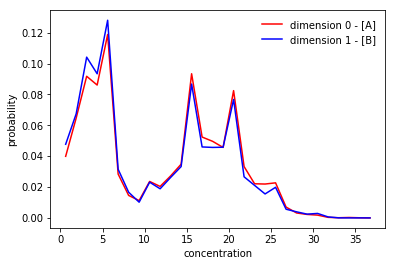

In [16]:
# First average over iterations
H = np.average(hist, axis=0)
print(H.shape)
# Next calculate the probability distribution in each dimension
H_x = np.sum(H, axis=0)
H_x = H_x/H_x.sum()
H_y = np.sum(H, axis=1)
H_y = H_y/H_y.sum()
print(H_x.shape, H_y.shape)
# Now plot both 
plt.plot(p['midpoints_0'][...], H_x, c='r', label='dimension 0 - [A]')
plt.plot(p['midpoints_1'][...], H_y, c='b', label='dimension 1 - [B]')
plt.ylabel("probability")
plt.xlabel("concentration")
plt.legend(frameon=False)
plt.show()
# We expect identical in each dimension since the model is symmetrical in A and B

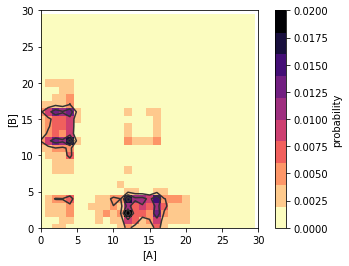

In [17]:
# Now plot color map 
plt.contour(H, np.arange(0.0, 0.020, 0.005), lw=2, colors='0.2')
im = plt.imshow(H, cmap=plt.get_cmap("magma_r", 10), vmax=0.02)
_ = plt.colorbar(im, label="probability")
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel("[A]")
plt.ylabel("[B]")
plt.show()

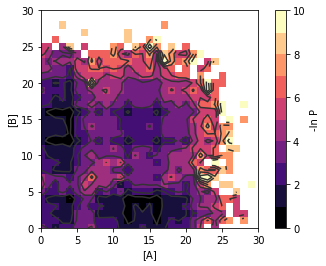

In [18]:
# Generally a -ln P makes things easier to see and converts the probability to a estimate of the free energy
lnp = -np.log(H)
lnp = lnp - lnp.min()
plt.contour(lnp, range(10), lw=2, colors='0.2')
im = plt.imshow(lnp, cmap=plt.get_cmap("magma", 10), vmax=10)
_ = plt.colorbar(im, label="-ln P")
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel("[A]")
plt.ylabel("[B]")
plt.show()

# Sample analysis

We can now use some of this information to analyze our data. Let's calculate a transition matrix from each voronoi center to each other center. We will then use the transition matrix to get a coarse graining to find phenotypes.

[[1.99e-02 1.17e-03 1.25e-02 ... 0.00e+00 2.24e-05 0.00e+00]
 [9.95e-04 1.43e-04 6.04e-04 ... 0.00e+00 0.00e+00 5.87e-05]
 [1.18e-02 8.44e-04 5.14e-03 ... 0.00e+00 5.23e-05 8.08e-06]
 ...
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [2.26e-04 0.00e+00 1.31e-04 ... 0.00e+00 2.44e-04 0.00e+00]
 [3.33e-06 3.88e-05 4.18e-07 ... 0.00e+00 0.00e+00 9.10e-07]]


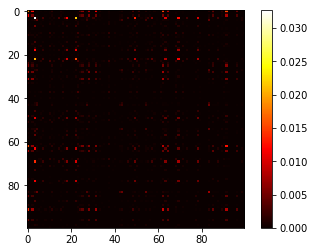

In [19]:
# some useful function definitions, all functions use 1-indexed iteration ids
def get_parent(iiter, hfile=h):
    return hfile['iterations/iter_%08d'%iiter]['seg_index']['parent_id']

def get_weight(iiter, hfile=h):
    return hfile['iterations/iter_%08d'%iiter]['seg_index']['weight']

def get_walk_counts(iiter, hfile=h):
    return hfile['summary']['n_particles'][iiter-1]

def get_assign(iiter, afile=a):
    return afile['assignments'][iiter-1,:,:]

# initialize the transition matrix to be calculated
tm_s = a['bin_labels'].shape[0]
tm = np.zeros((tm_s, tm_s))
# Start looping over our iterations
ctr = 0
for iiter, iter_arr in enumerate(a['assignments']):
    ctr += 1
    if iiter > 1:
        # converting 0-index to 1-index, each function uses 1-index values here
        # get number of walkers
        n_walks = get_walk_counts(iiter+1)
        # get the parents of each walker in this iteration
        parents = get_parent(iiter+1)
        # get the assignments for each walker
        assign = get_assign(iiter)
        # get the weights for each walker
        weights = get_weight(iiter+1)
        for iwalk in range(n_walks):
            # from assignment of current walker
            walk = iter_arr[iwalk]
            # to parent 
            parent = parents[iwalk]
            # parent assignment
            prev_assign = assign[parent] 
            # with weight of the walker
            weight = weights[iwalk]
            # building up the transition matrix, each iteration have 2 values in our case
            tm[walk[0]][walk[1]] += weight
            # also need to consider from parent walkers last point to child parents first
            tm[prev_assign[1]][walk[0]] += weight
# Average over the # of iterations
tm /= ctr

# Can just load if this doesn't work
#tm = np.load('pre_prepped_results/tm.npy')
print(tm)
im = plt.imshow(tm, cmap=plt.get_cmap('hot'))
_ =plt.colorbar(im)

Using the transition matrix we can make a markov chain over the voronoi bins, the transition matrix has to be symmetrized to fulfill equilibrium conditions for future analysis.

[[1.51e-01 8.22e-03 9.24e-02 ... 0.00e+00 9.45e-04 1.27e-05]
 [8.63e-02 1.14e-02 5.77e-02 ... 0.00e+00 0.00e+00 3.89e-03]
 [1.81e-01 1.08e-02 7.66e-02 ... 0.00e+00 1.37e-03 6.33e-05]
 ...
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [1.45e-02 0.00e+00 1.07e-02 ... 0.00e+00 2.84e-02 0.00e+00]
 [7.27e-04 2.13e-02 1.85e-03 ... 0.00e+00 0.00e+00 3.97e-04]]


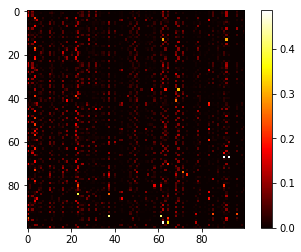

In [20]:
stm = ahelper.symmetrize(tm)
# Row normalize to turn this into a proper row stochastic transition matrix
ntm = ahelper.row_normalize(stm)
print(ntm)
im = plt.imshow(ntm, cmap=plt.get_cmap('hot'))
_ =plt.colorbar(im)

Use pyEmma to do PCCA+ coarse graining (maximizes self-transition and minimizes cross-state transitions, requires equilibrium transition matrix), finding metastable states (phenotypes) and the transition matrix between them.

[[ 6.36e-01  1.09e-02  1.72e-01  1.81e-01]
 [ 8.80e-04  8.43e-01  8.02e-02  7.57e-02]
 [ 6.61e-02  2.65e-02  9.12e-01 -4.64e-03]
 [ 5.84e-02  2.57e-02  3.54e-03  9.12e-01]]
[0.13 0.13 0.38 0.36]


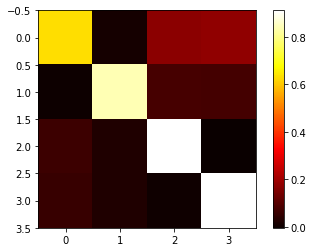

In [21]:
MSM = pe.msm.MSM(ntm, reversible=True)
pcca = MSM.pcca(4) # We know we have 4 states in this case, skipping timescales calculation here
p = pcca.coarse_grained_stationary_probability
ctm = pcca.coarse_grained_transition_matrix
# This is our coarse grained, 4x4 transition matrix
print(ctm)
# p is the stationary probability distribution as implied by our transition matrix
print(p)
im = plt.imshow(ctm, cmap=plt.get_cmap('hot'))
_ = plt.colorbar(im)

let's find out what our coarse grained states look like on average, the first two values are \[A\] and \[B\], the rest are gene states. The states should correspond to the wells that are visible in the histograms we plotted using w_pdist output. 

In [22]:
mstable_assign = pcca.metastable_assignment
# using the bin labels (voronoi centers) and finding the average value for the centers
bin_labels = ahelper.get_bin_labels(a)

print("metastable state 0")
print(bin_labels[mstable_assign.T==0].mean(axis=0))
print("metastable state 1")
print(bin_labels[mstable_assign.T==1].mean(axis=0))
print("metastable state 2")
print(bin_labels[mstable_assign.T==2].mean(axis=0))
print("metastable state 3")
print(bin_labels[mstable_assign.T==3].mean(axis=0))

metastable state 0
[4.22 2.78 0.56 0.   0.44 0.56 0.   0.44]
metastable state 1
[21.64 21.81  0.    0.98  0.02  0.    1.    0.  ]
metastable state 2
[ 4.86 21.18  0.21  0.14  0.64  0.    0.96  0.04]
metastable state 3
[20.71  4.52  0.05  0.95  0.    0.19  0.05  0.76]


If everything went well, each state should correspond to one of the wells. Let's see if these matchup well with expected states on the probability distribution by plotting some data on top of the distribution and coloring according to the label we assigned.

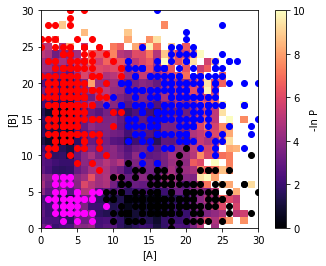

In [23]:
# have some colors assigned for each state
state_colors = {0: "#FF00FF", 1: "#0000FF", 2: "#FF0000", 3: "#000000"}
# pull sample iteration, say iteration 100 (last iteration)
assigned_walkers = a['assignments'][99]
# re-plot the -lnP 
im = plt.imshow(lnp, cmap=plt.get_cmap("magma"), vmax=10)
_ = plt.colorbar(im, label="-ln P")
# plot assigned values with appropriate colors
n_walkers = h['summary'][99]['n_particles']
for iwalk in range(n_walkers):
    # get the progress coordinate for the walker, assume last time point is enough
    pcrd = h['iterations/iter_%08d'%100]['pcoord'][iwalk,-1,:]
    assigned = assigned_walkers[iwalk]
    # pcrds as x & y for the plot
    x, y = pcrd[0], pcrd[1]
    plt.plot(x, y, c=state_colors[mstable_assign[assigned[-1]]], lw=0, marker="o")
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel("[A]")
plt.ylabel("[B]")
plt.show()

Now that we have assignments for the 4 states we can visualize the network using different colors for each state. Let's start by plotting the entire network, including every voronoi center. For this we will use the transition matrix we calculated where each node is weighted by their steady state probabilities and each edge weighted by the transition probability as given by the transition matrix.

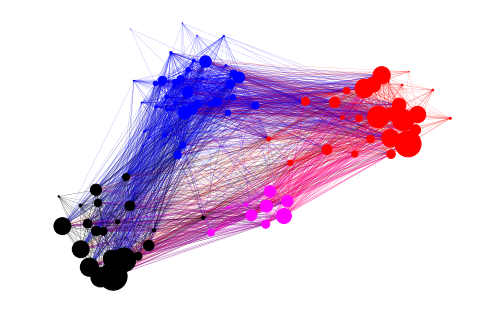

In [24]:
# Start with full network
FG = nx.DiGraph()
tm = pcca.transition_matrix
edge_sizes = pcca.transition_matrix
node_sizes = pcca.stationary_probability
# building network
for i in range(tm.shape[0]):
    if node_sizes[i] > 0:
        FG.add_node(i, weight=float(node_sizes[i]))
for i in range(tm.shape[0]):
    for j in range(tm.shape[1]):
        if i != j:
            if edge_sizes[i][j] > 1e-3:
                FG.add_edge(i, j, weight=float(edge_sizes[i][j]))
nx.draw(FG, pos=nx.spring_layout(FG, k=0.1), 
            node_color=[state_colors[mstable_assign[i]] for i in FG.nodes()], node_size=[i*10000 for i in node_sizes],
            edge_color=[state_colors[mstable_assign[i[0]]] for i in FG.edges()], width=0.1, arrows=False)
plt.show()
plt.close()

And now we can visualize the coarse grained network, using the same method.

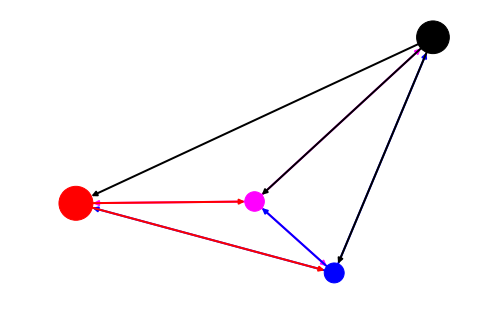

In [25]:
# Do the coarse grained network next
CG = nx.DiGraph()
tm = pcca.coarse_grained_transition_matrix
edge_sizes = pcca.coarse_grained_transition_matrix
node_sizes = pcca.coarse_grained_stationary_probability
# building network
for i in range(tm.shape[0]):
    if node_sizes[i] > 0:
        CG.add_node(i, weight=float(node_sizes[i]), color=state_colors[mstable_assign[i]])
for i in range(tm.shape[0]):
    for j in range(tm.shape[1]):
        if i != j:
            if edge_sizes[i][j] > 0:
                CG.add_edge(i, j, weight=float(edge_sizes[i][j]))
nx.draw(CG, pos=nx.spring_layout(CG), 
            node_color=[state_colors[i] for i in CG.nodes()], node_size=[i*3000 for i in node_sizes],\
            edge_color=[state_colors[i[0]] for i in CG.edges()], width=2, )
plt.show()

One potentially important thig is to plot your bin boundaries. It's pretty tricky for voronoi binning, here is some sample code.

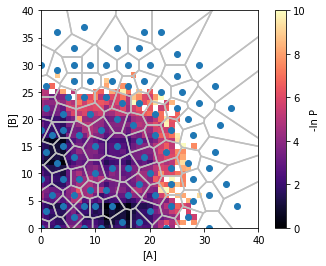

In [26]:
im = plt.imshow(lnp, cmap=plt.get_cmap("magma"), vmax=10)
_ = plt.colorbar(im, label="-ln P")
# Overlay voronoi bins
# Taken from @synapticarbors on GitHub, see analysis_helper.py for details
X = bin_labels[:,0]
Y = bin_labels[:,1]
plt.scatter(X,Y)
segments = ahelper.voronoi(X,Y)
lines = matplotlib.collections.LineCollection(segments, color='0.75')
axes = plt.gca()
axes.add_collection(lines)
# done
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel("[A]")
plt.ylabel("[B]")
plt.show()

A common thing to see for single trajectories (brute force/BF) for rule based models is time series of a particular property (e.g. \[A\] here). Since WE gives continuous trajectories we can do the same thing for any walker we have by tracing it up the history tree. We can compare some sample BF simulations to WE trajectories.

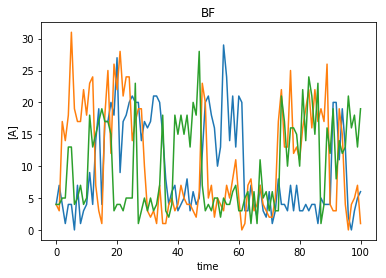

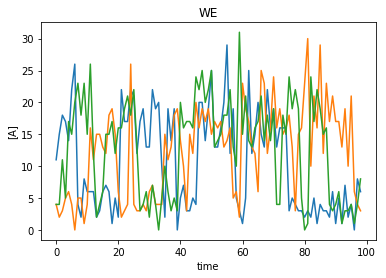

In [27]:
# Each tau was 10,000 and we ran for 100 iterations, simulations that are 10^6 long at max
# let's compare the BF data
BF_data = np.load('pre_prepped_results/bf_data.npy')
#for i in range(BF_data.shape[0]):
for i in range(3):
    A_conc = BF_data[i,:,7][::10] # every 10k, same as every iter for WE
    plt.plot(range(len(A_conc)), A_conc)
plt.title("BF")
plt.xlabel("time")
plt.ylabel("[A]")
plt.show()

# pulling random # of walkers from last iteration
n_walkers = h['summary'][-1]['n_particles']
#random_walker_ids = np.random.randint(0, high=n_walkers, size=10)
random_walker_ids = np.random.randint(0, high=n_walkers, size=3)
random_walker_tuples = [(99,i) for i in random_walker_ids] # only want last iteration
# let's trace'em all
def trace_walker(walk_tuple, walk_data):
    iiter, iwalk = walk_tuple
    # find walker assignment
    assignment = a['assignments'][iiter][iwalk,-1]
    pcoord = h['iterations/iter_%08d'%(iiter+1)]['pcoord'][iwalk,-1,:]
    walk_data.append((walk_tuple, assignment, pcoord))
    if iiter == 1:
        return walk_data
    else:
        parent = h['iterations/iter_%08d'%(iiter+1)]['seg_index']['parent_id'][iwalk]
        walk_data = trace_walker((iiter-1,parent), walk_data=walk_data)

for walk_tpl in random_walker_tuples:
    walk_data = []
    trace_walker(walk_tpl, walk_data)
    A_conc = [i[2][0] for i in walk_data]
    plt.plot(range(len(A_conc)), A_conc)
plt.title("WE")
plt.xlabel("time")
plt.ylabel("[A]")
plt.show()